# Analisis Opini Publik mengenai Ibu Kota Negara Baru (IKN)
<br>
Proyek akhir Python Data Science & Machine Learning Course oleh Azzahid A. F. Poeloengan

## Part 0 - Pendahuluan

```
Pada bulan April 2019, pemerintah Indonesia di bawah kepemimpinan Presiden Joko Widodo mengangkat wacana pemindahan ibu kota negara. Presiden Joko Widodo memutuskan untuk memindahkan ibu kota negara ke luar Pulau Jawa. Pada Agustus 2019, ibu kota negara baru diumumkan pindah ke Provinsi Kalimantan Timur dengan nama Nusantara. Putusan ini pun sudah diperkuat melalui Undang-Undang Ibu Kota Negara (UU-IKN) yang disahkan oleh DPR pada 18 Januari 2022.

Pemindahan ibu kota ini tentunya merupakan suatu isu yang menjadi sorotan publik. Berbagai macam opini baik negatif maupun positif tersebar di kalangan publik. Terlebih lagi, pemindahan ibu kota ini letaknya jauh dengan ibu kota negara saat ini yaitu DKI Jakarta. Maka dari itu dilakukan analisis opini publik mengenai pemindahan ibu kota negara baru.
```

In [1]:
# Semua library yang dibutuhkan
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import re, string, nltk, json, tqdm, gensim, tweepy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from pprint import pprint
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from urllib.request import urlopen
from bs4 import BeautifulSoup
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from wordcloud import WordCloud

## Part 1 - Data Collection

#### 1.1 Tweets Collection

In [2]:
# Baca token untuk akses twitter API
with open("token.json")as tok:
  tokens = json.load(tok)

bearer_token = tokens['bearer_token']
api_key = tokens['api_key']
api_key_secret = tokens['api_key_secret']
access_token = tokens['access_token']
access_token_secret = tokens['access_token_secret']

In [31]:
# Autentikasi twitter API
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

# Kata kunci pencarian topik ini menggunakan hashtag agar lebih relevan
keyword = "#IbuKotaNegara #IKN"
search_query = keyword + " -filter:retweets"

In [33]:
# Membuat request tweets sesuai kata kunci yang sudah ditentukan
response = tweepy.Cursor(
    api.search_tweets,
    q = search_query,
    lang = 'id',
    until = '2022-03-02',
    result_type = 'recent',
    tweet_mode = 'extended'
    ).items(600)

# Menyimpan data tweets ke dalam array dan pandas dataframe dan menyimpan ke dalam file csv
tweets_array = []
for tweet in response:
    tweets_array.append(tweet.full_text.strip())

df_tweets = pd.DataFrame(tweets_array, columns = ['tweet'])

# Menampilkan dataframe
display(df_tweets.head())

,tweet
0,Dengan dipimpin oleh Kepala Otorita yang ditun...
1,IKN Nusantara dijuluki Kota Dunia untuk Semua....
2,Ibu kota baru juga akan menjadi penggerak ekon...
3,Ibu kota baru akan menjadi kota yang keren den...
4,Merata untuk semua. Percepatan pembangunan kin...


#### 1.2 News Collection

In [34]:
# Webscraping dengan sumber tempo (Diperoleh tanggal 6 Maret 2022)

topic = 'ikn'

address = f'https://www.tempo.co/tag/{topic}?type=berita'
html = urlopen(address)
data = BeautifulSoup(html, 'html.parser')

In [35]:
# Mengambil parent element dari berita-berita dengan topik IKN
news_table = data.findAll('div', {'class':'w-70'})[0]
rows = news_table.findAll('li')

ikn_list = []
for row in rows:

    for cell in row.findAll('p'):
        news_desc = cell.get_text()

    for cell in row.findAll('span'):
        news_date = cell.get_text()

    ikn_list.append((news_date, news_desc))

# Dipilih deskripsi berita, bukan judul agar lebih relevan dengan isi berita


# Menjadikan dataframe dan menyimpan dalam bentuk csv
news_dataframe = pd.DataFrame(ikn_list, columns=['tanggal', 'deskripsi_berita'])

# Menampilkan dataframe
display(news_dataframe.head())

,tanggal,deskripsi_berita
0,6 Maret 2022 06:01 WIB,Berita terpopuler ekonomi dan bisnis sepanjang...
1,5 Maret 2022 09:54 WIB,KontraS menyoroti langkah pemerintah dalam pem...
2,5 Maret 2022 08:59 WIB,Menkominfo Johnny Plate menyebutkan ibu kota n...
3,5 Maret 2022 06:25 WIB,KontraS beranggapan proyek IKN berpotensi memi...
4,4 Maret 2022 20:27 WIB,Pemerintah terus mengebut persiapan-persiapan ...


## Part 2 - Data Preparation

In [7]:
# Fungsi-fungsi yang diperlukan

## Case Folding
def case_folding(data):
    data = data.lower()
    data = re.sub('@[^\s]+','',data)
    data = ' '.join(re.sub("(#[A-Za-z0-9]+)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",data).split())
    data = re.sub(r"\d+", "", data)
    data = re.sub(r"\n","",data)
    data = re.sub(r"\t","",data)
    data = data.translate(str.maketrans("","",string.punctuation))
    return data

## Remove Stopwords
def remove_stopwords(data):
    sw_indonesia = stopwords.words("indonesian")
    data  = [word for word in data if word not in sw_indonesia]
    data = ' '.join(data)
    return data

## Stemming
def words_stemming(data):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    data = stemmer.stem(data)
    return data     

## Remove Slang
def remove_slang(data, slang_data):
    remove_slang = []
    for tweet in clean_text_tweets:
        word_list = []
        for word in word_tokenize(tweet):
            if slang_data.get(word):
                word = slang_data[word]
            word_list.append(word)
        remove_slang.append(' '.join(word_list))
    return remove_slang

## Distribusi Frekuensi Kata
def word_frequency(list):
    tokenizedData = []
    for sentence in list:
        t_kata = word_tokenize(sentence)
        tokenizedData += t_kata

    return FreqDist(tokenizedData)

#### 2.1 Tweets Data Preprocessing

In [36]:
# Menampilkan data tweets yang telah diperoleh
display(df_tweets.head())

,tweet
0,Dengan dipimpin oleh Kepala Otorita yang ditun...
1,IKN Nusantara dijuluki Kota Dunia untuk Semua....
2,Ibu kota baru juga akan menjadi penggerak ekon...
3,Ibu kota baru akan menjadi kota yang keren den...
4,Merata untuk semua. Percepatan pembangunan kin...


In [37]:
# Menjalankan pembersihan data
clean_tweets = []
for i in range(len(df_tweets['tweet'])):
    data = case_folding(df_tweets['tweet'][i])
    data = word_tokenize(data)
    data = remove_stopwords(data)
    data = words_stemming(data)
    clean_tweets.append(data)


In [38]:
# Melihat kata-kata yang sering muncul untuk menghilangkan kata-kata tidak baku
    
print(word_frequency(clean_tweets).most_common(40))

[('ikn', 381), ('dukung', 266), ('pindah', 168), ('nusantara', 157), ('kota', 110), ('negara', 87), ('bangun', 83), ('kalimantan', 76), ('indonesia', 65), ('kaltim', 61), ('balikpapan', 53), ('alas', 50), ('masyarakat', 49), ('bem', 44), ('pesantren', 41), ('tokoh', 33), ('penuh', 31), ('deklarasi', 31), ('kampus', 29), ('timur', 27), ('ketua', 26), ('kawal', 25), ('sistem', 25), ('rencana', 24), ('api', 24), ('kereta', 23), ('kawasan', 23), ('kepala', 22), ('mahasiswa', 22), ('perata', 22), ('maju', 22), ('otorita', 21), ('ekonomi', 21), ('transportasi', 21), ('dewan', 20), ('sepakat', 19), ('usaha', 19), ('mui', 19), ('sejahtera', 16), ('eksekutif', 14)]


In [39]:
# Tidak terlihat ada slang ataupun kata-kata tidak baku yang sering muncul
df_tweets['clean_tweet'] = clean_tweets

In [40]:
# Langkah terakhir menghapus duplikat dan kolom kosong setelah pembersihan
df_tweets = df_tweets.drop_duplicates()

nan_value = float("NaN")
df_tweets.replace("", nan_value, inplace=True)
df_tweets.dropna(subset = ["clean_tweet"], inplace=True)
df_tweets = df_tweets.reset_index(drop=True)

display(df_tweets)

,tweet,clean_tweet
0,Dengan dipimpin oleh Kepala Otorita yang ditun...,pimpin kepala otorita langsung presiden bangun...
1,IKN Nusantara dijuluki Kota Dunia untuk Semua....,ikn nusantara juluk kota dunia wujud kota idea...
2,Ibu kota baru juga akan menjadi penggerak ekon...,kota gerak ekonomi
3,Ibu kota baru akan menjadi kota yang keren den...,kota kota keren jaga lingkung
4,Merata untuk semua. Percepatan pembangunan kin...,rata cepat bangun pulau jawa alih indonesia se...
...,...,...
510,MUI Balikpapan Dukung Pemindahan IKN ke Kalima...,mui balikpapan dukung pindah ikn kalimantan timur
511,MUI Balikpapan Dukung Pemindahan IKN ke Kalima...,mui balikpapan dukung pindah ikn kalimantan timur
512,Si Ngerik Content Creator Asal Balikpapan Duku...,si ngerik content creator balikpapan dukung ik...
513,Pengurus Komando Pertahanan Adat Dayak Kaliman...,urus komando tahan adat dayak kalimantan kpadk...


In [41]:
# Menyimpan dataframe ke file csv
df_tweets.to_csv('ikn_tweets.csv', index = False)

display(df_tweets)

,tweet,clean_tweet
0,Dengan dipimpin oleh Kepala Otorita yang ditun...,pimpin kepala otorita langsung presiden bangun...
1,IKN Nusantara dijuluki Kota Dunia untuk Semua....,ikn nusantara juluk kota dunia wujud kota idea...
2,Ibu kota baru juga akan menjadi penggerak ekon...,kota gerak ekonomi
3,Ibu kota baru akan menjadi kota yang keren den...,kota kota keren jaga lingkung
4,Merata untuk semua. Percepatan pembangunan kin...,rata cepat bangun pulau jawa alih indonesia se...
...,...,...
510,MUI Balikpapan Dukung Pemindahan IKN ke Kalima...,mui balikpapan dukung pindah ikn kalimantan timur
511,MUI Balikpapan Dukung Pemindahan IKN ke Kalima...,mui balikpapan dukung pindah ikn kalimantan timur
512,Si Ngerik Content Creator Asal Balikpapan Duku...,si ngerik content creator balikpapan dukung ik...
513,Pengurus Komando Pertahanan Adat Dayak Kaliman...,urus komando tahan adat dayak kalimantan kpadk...


#### 2.2 News data Preprocessing

In [14]:
# Menampilkan data berita yang sudah dikumpulkan
display(news_dataframe.head())

,tanggal,deskripsi_berita
0,6 Maret 2022 06:01 WIB,Berita terpopuler ekonomi dan bisnis sepanjang...
1,5 Maret 2022 09:54 WIB,KontraS menyoroti langkah pemerintah dalam pem...
2,5 Maret 2022 08:59 WIB,Menkominfo Johnny Plate menyebutkan ibu kota n...
3,5 Maret 2022 06:25 WIB,KontraS beranggapan proyek IKN berpotensi memi...
4,4 Maret 2022 20:27 WIB,Pemerintah terus mengebut persiapan-persiapan ...


In [50]:
# Membersihkan data
clean_news = []
for i in range(len(news_dataframe['deskripsi_berita'])):
    temp = case_folding(news_dataframe['deskripsi_berita'][i])
    temp = word_tokenize(temp)
    temp = remove_stopwords(temp)
    temp = words_stemming(temp)
    clean_news.append(temp)

In [51]:
print(word_frequency(clean_news).most_common(20))

[('ikn', 33), ('perintah', 15), ('kota', 11), ('negara', 11), ('jokowi', 11), ('pindah', 7), ('bangun', 7), ('presiden', 7), ('nusantara', 7), ('bisnis', 6), ('jakarta', 6), ('tni', 6), ('menteri', 6), ('bambang', 6), ('berita', 5), ('ekonomi', 5), ('kalimantan', 5), ('timur', 5), ('indonesia', 5), ('ruang', 5)]


In [52]:
# Mengganti format tanggal menjadi tipe datetime

for i in range(len(news_dataframe['tanggal'])):
    news_dataframe['tanggal'][i] = news_dataframe['tanggal'][i].replace(' Maret ', '-03-').replace(' Februari ', '-02-').replace(' WIB','')
    news_dataframe['tanggal'][i] = datetime.strptime(news_dataframe['tanggal'][i], '%d-%m-%Y %H:%M')

In [53]:
# Tidak ada kata-kata tidak baku, maka data dapat disimpan ke file csv
news_dataframe['berita_clean'] = clean_news
news_dataframe.to_csv('ikn_news.csv', index = False)

display(news_dataframe.head())

,tanggal,deskripsi_berita,berita_clean
0,2022-03-06 06:01:00,Berita terpopuler ekonomi dan bisnis sepanjang...,berita populer ekonomi bisnis sabtu maret tips...
1,2022-03-05 09:54:00,KontraS menyoroti langkah pemerintah dalam pem...,kontras sorot langkah perintah pindah kota neg...
2,2022-03-05 08:59:00,Menkominfo Johnny Plate menyebutkan ibu kota n...,menkominfo johnny plate kota negara ikn sepenu...
3,2022-03-05 06:25:00,KontraS beranggapan proyek IKN berpotensi memi...,kontras anggap proyek ikn potensi picu langgar...
4,2022-03-04 20:27:00,Pemerintah terus mengebut persiapan-persiapan ...,perintah kebut siap siap bangun ikn rencana pi...


#### 2.3 Training Data Preprocessing

Sumber dataset:
```
Nurjanah, W.E., Perdana, R.S., & Fauzi, M.A. (2017). Analisis Sentimen Terhadap Tayangan Televisi Berdasarkan Opini Masyarakat pada Media Sosial Twitter menggunakan Metode K-Nearest Neighbor dan Pembobotan Jumlah Retweet. Jurnal Pengembangan Teknologi Informasi Dan Ilmu Komputer, 1(12), 1750-1757. Diambil dari http://j-ptiik.ub.ac.id/index.php/j-ptiik/article/view/631
```

In [19]:
data_labeled = pd.read_csv('data_tweet_labeled.csv')
display(data_labeled)

,Id,Sentiment,Acara TV,Jumlah Retweet,Text Tweet
0,1,positive,HitamPutihTransTV,12,"Undang @N_ShaniJKT48 ke hitamputih, pemenang S..."
1,2,positive,HitamPutihTransTV,6,Selamat berbuka puasa Semoga amal ibadah hari ...
2,3,positive,HitamPutihTransTV,9,"Ada nih di trans7 hitam putih, dia dpt penghar..."
3,4,positive,HitamPutihTransTV,2,selamat ya mas @adietaufan masuk hitamputih
4,5,positive,HitamPutihTransTV,1,Asiknya nonton Hitam Putih Trans7
...,...,...,...,...,...
395,396,negative,MataNajwaMetroTV,0,ini apa banget deh gw paling kesel klo orang2 ...
396,397,negative,MataNajwaMetroTV,0,Orang miskin semakin miskin klo sekolah melaku...
397,398,negative,MataNajwaMetroTV,0,"ga boLeh emosi, cepat tua, nonton #matanajwame..."
398,399,negative,MataNajwaMetroTV,0,dr penampilan saja kyk preman taunya bkin kisr...


In [20]:
# Membuang kolom yang tidak diperlukan
data_labeled = data_labeled.drop(columns = ['Id', 'Acara TV', 'Jumlah Retweet'])
data_labeled.head()

,Sentiment,Text Tweet
0,positive,"Undang @N_ShaniJKT48 ke hitamputih, pemenang S..."
1,positive,Selamat berbuka puasa Semoga amal ibadah hari ...
2,positive,"Ada nih di trans7 hitam putih, dia dpt penghar..."
3,positive,selamat ya mas @adietaufan masuk hitamputih
4,positive,Asiknya nonton Hitam Putih Trans7


In [21]:
# Mengubah nilai kolom Sentiment menjadi biner
for i in range(len(data_labeled['Sentiment'])):
    if data_labeled['Sentiment'][i] == 'positive':
        data_labeled['Sentiment'][i] = 1
    else:
        data_labeled['Sentiment'][i] = 0

display(data_labeled)

,Sentiment,Text Tweet
0,1,"Undang @N_ShaniJKT48 ke hitamputih, pemenang S..."
1,1,Selamat berbuka puasa Semoga amal ibadah hari ...
2,1,"Ada nih di trans7 hitam putih, dia dpt penghar..."
3,1,selamat ya mas @adietaufan masuk hitamputih
4,1,Asiknya nonton Hitam Putih Trans7
...,...,...
395,0,ini apa banget deh gw paling kesel klo orang2 ...
396,0,Orang miskin semakin miskin klo sekolah melaku...
397,0,"ga boLeh emosi, cepat tua, nonton #matanajwame..."
398,0,dr penampilan saja kyk preman taunya bkin kisr...


In [22]:
# Membersihkan data
clean_text_tweets = []
for i in range(len(data_labeled['Text Tweet'])):
    data = case_folding(data_labeled['Text Tweet'][i])
    data = word_tokenize(data)
    data = remove_stopwords(data)
    data = words_stemming(data)
    clean_text_tweets.append(data)

In [23]:
print(word_frequency(clean_text_tweets).most_common(20))

[('mata', 63), ('najwa', 60), ('yg', 54), ('hitam', 40), ('putih', 39), ('acara', 37), ('orang', 36), ('nonton', 29), ('keren', 29), ('ga', 28), ('tv', 26), ('indonesia', 21), ('trans', 19), ('ahok', 19), ('metro', 19), ('banget', 18), ('inspirasi', 17), ('malam', 16), ('aja', 16), ('anak', 16)]


In [24]:
# Ditemukan beberapa kata-kata slang maka data perlu dibersihkan kembali
slang_list = {
    'yg':'yang',
    'ga':'tidak',
    'banget':'sangat',
    'aja':'saja'
}

clean_text_tweets = remove_slang(clean_text_tweets,slang_list)

temp_clean_text_tweets =[]
for i in range(len(clean_text_tweets)):
    data = word_tokenize(clean_text_tweets[i])
    data = remove_stopwords(data)
    temp_clean_text_tweets.append(data)

clean_text_tweets = temp_clean_text_tweets


In [25]:
data_labeled['clean_tweets'] = clean_text_tweets
data_labeled.to_csv('clean_data_tweet_labeled.csv', index=False)

## Part 3 - Data Processing

### Text Analysis

In [26]:
# Fungsi-fungsi yang dibutuhkan

## Distribusi frekuensi jumlah huruf
def char_dist(data):
    fig, axs = plt.subplots(1, 1, tight_layout=True)
    bin_range = np.arange(0, 260, 10)

    N, bins, patches = axs.hist(data.str.len(),bins=bin_range)
    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())

    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)

    plt.title('Distribusi Frekuensi Jumlah Huruf')
    plt.show()


## Distribusi frekuensi jumlah kata
def word_dist(data):
    fig, axs = plt.subplots(1, 1, tight_layout=True)
    bin_range = np.arange(0, 35)

    N, bins, patches = axs.hist(data.str.split().map(lambda x : len(x)),bins=bin_range)
    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())

    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    plt.title('Distribusi Frekuensi Jumlah Kata')
    plt.show()

## Distribusi frekuensi panjang kata rata-rata
def word_length_avg_dist(data):
    fig, axs = plt.subplots(1, 1, tight_layout=True)

    N, bins, patches = axs.hist(data.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)))
    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())

    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    plt.title('Distribusi Frekuensi Panjang Kata Rata-Rata')
    plt.show()


## Distribusi frekuensi kata yang sering muncul
def word_freq_dist(data):
    word_frequency(data).plot(10,cumulative=False, title='Distribusi Frekuensi Kata Popular')

## Distribusi Bigram
def bigram_dist(data):
    bigram_data = []
    for title in data:
        a = word_tokenize(title)
        bigram_data += a

    result = pd.Series(nltk.ngrams(bigram_data, 2)).value_counts()[:10]
    return result

### Tweets Data Analysis

In [42]:
# Menampilkan data yang sudah bersih
display(df_tweets.head())

## Pertama, akan dilakukan Text Analysis menggunakan fungsi-fungsi yang sudah dibuat

,tweet,clean_tweet
0,Dengan dipimpin oleh Kepala Otorita yang ditun...,pimpin kepala otorita langsung presiden bangun...
1,IKN Nusantara dijuluki Kota Dunia untuk Semua....,ikn nusantara juluk kota dunia wujud kota idea...
2,Ibu kota baru juga akan menjadi penggerak ekon...,kota gerak ekonomi
3,Ibu kota baru akan menjadi kota yang keren den...,kota kota keren jaga lingkung
4,Merata untuk semua. Percepatan pembangunan kin...,rata cepat bangun pulau jawa alih indonesia se...


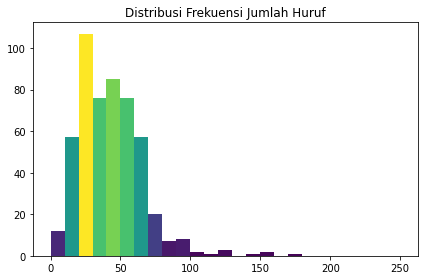

In [43]:
char_dist(df_tweets['clean_tweet'])

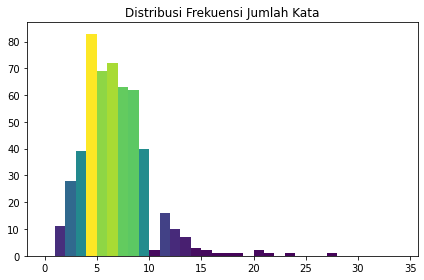

In [44]:
word_dist(df_tweets['clean_tweet'])

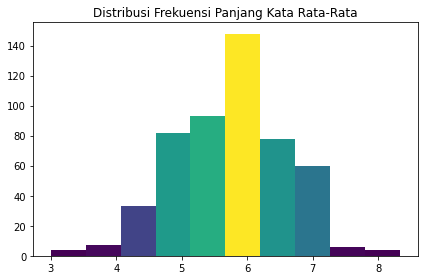

In [45]:
word_length_avg_dist(df_tweets['clean_tweet'])

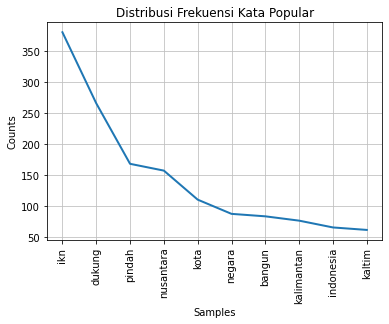

In [46]:
word_freq_dist(df_tweets['clean_tweet'])

In [47]:
bigram_dist(df_tweets['clean_tweet'])

(ikn, nusantara)    148
(dukung, ikn)       101
(pindah, ikn)        93
(kota, negara)       79
(pindah, kota)       57
(bangun, ikn)        52
(alas, pindah)       42
(dukung, pindah)     41
(dukung, bangun)     39
(dukung, penuh)      31
dtype: int64

##### Model Fitting

In [65]:
df_labeled = pd.read_csv('clean_data_tweet_labeled.csv')
df_labeled.head()

,Sentiment,Text Tweet,clean_tweets
0,1,"Undang @N_ShaniJKT48 ke hitamputih, pemenang S...",undang hitamputih menang ssk jkt mjkt layak un...
1,1,Selamat berbuka puasa Semoga amal ibadah hari ...,selamat buka puasa moga amal ibadah ni terima ...
2,1,"Ada nih di trans7 hitam putih, dia dpt penghar...",nih trans hitam putih dpt harga norwegia
3,1,selamat ya mas @adietaufan masuk hitamputih,selamat ya mas masuk hitamputih
4,1,Asiknya nonton Hitam Putih Trans7,asiknya nonton hitam putih trans


In [66]:
# Inisialisasi model
vectorizer = TfidfVectorizer (max_features=2500)
model_g = GaussianNB()

In [67]:
# Mengubah teks menjadi TF-IDF vectorizer
v_data = vectorizer.fit_transform(df_labeled['clean_tweets']).toarray()

In [68]:
# Memisahkan data training dan test 80:20
X_train, X_test, y_train, y_test = train_test_split(v_data, df_labeled['Sentiment'], test_size=0.2, random_state=12)

# Fitting data training ke model
model_g.fit(X_train,y_train)

# Melakukan evaluasi model menggunakan data test
y_preds = model_g.predict(X_test)

print(confusion_matrix(y_test,y_preds))
print(classification_report(y_test,y_preds))

[[31  5]
 [ 7 37]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        36
           1       0.88      0.84      0.86        44

    accuracy                           0.85        80
   macro avg       0.85      0.85      0.85        80
weighted avg       0.85      0.85      0.85        80



#### Tweet Data

In [69]:
# Kedua, dilakukan analisis sentimen menggunakan naive bayes dengan dataset training yang sudah ada

v_data = vectorizer.transform(df_tweets["clean_tweet"]).toarray()
y_classification = model_g.predict(v_data)

df_tweets["Sentiment"] = list(y_classification)

display(df_tweets)

,tweet,clean_tweet,Sentiment
0,Dengan dipimpin oleh Kepala Otorita yang ditun...,pimpin kepala otorita langsung presiden bangun...,0
1,IKN Nusantara dijuluki Kota Dunia untuk Semua....,ikn nusantara juluk kota dunia wujud kota idea...,0
2,Ibu kota baru juga akan menjadi penggerak ekon...,kota gerak ekonomi,0
3,Ibu kota baru akan menjadi kota yang keren den...,kota kota keren jaga lingkung,0
4,Merata untuk semua. Percepatan pembangunan kin...,rata cepat bangun pulau jawa alih indonesia se...,0
...,...,...,...
510,MUI Balikpapan Dukung Pemindahan IKN ke Kalima...,mui balikpapan dukung pindah ikn kalimantan timur,0
511,MUI Balikpapan Dukung Pemindahan IKN ke Kalima...,mui balikpapan dukung pindah ikn kalimantan timur,0
512,Si Ngerik Content Creator Asal Balikpapan Duku...,si ngerik content creator balikpapan dukung ik...,1
513,Pengurus Komando Pertahanan Adat Dayak Kaliman...,urus komando tahan adat dayak kalimantan kpadk...,0


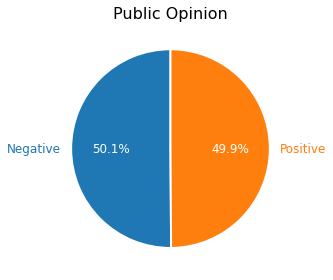

In [70]:
labels = ['Negative', 'Positive']

fig, ax = plt.subplots()
patches, texts, pcts = ax.pie( df_tweets['Sentiment'].value_counts(), 
        labels=labels, autopct='%.1f%%',
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'},
        textprops={'size': 'large'},
        startangle=90
        )
ax.set_title('Public Opinion', fontsize=16)
plt.setp(pcts, color='white')
fig.set_facecolor('white')
for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.tight_layout()
plt.show()

In [71]:
positive_tweets = df_tweets.loc[df_tweets['Sentiment']==1]
negative_tweets = df_tweets.loc[df_tweets['Sentiment']==0]


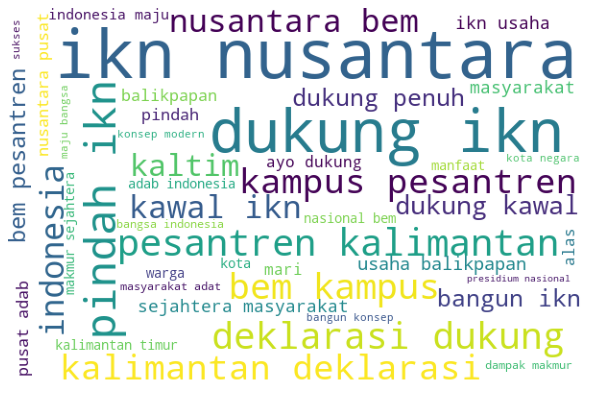

In [72]:
wordcloud_pos = WordCloud(width = 600, height = 400,
                background_color ='white',
                min_font_size = 10).generate(' '.join(positive_tweets['clean_tweet']))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_pos)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

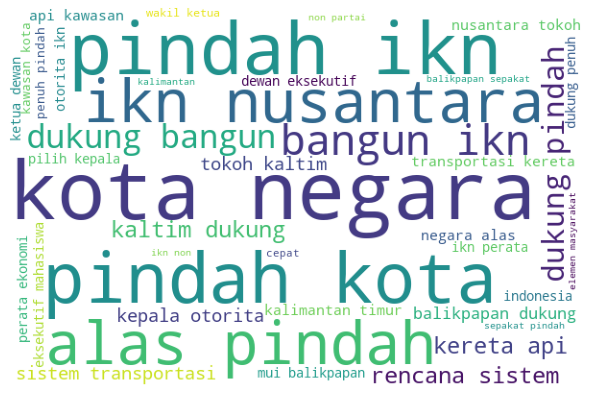

In [73]:
wordcloud_neg = WordCloud(width = 600, height = 400,
                background_color ='white',
                min_font_size = 10).generate(' '.join(negative_tweets['clean_tweet']))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_neg)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### News Data Analysis

In [85]:
# Fungsi mencari Nilai Koheren untuk Topic Extraction
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(
        corpus=doc_term_matrix,
        id2word=dictionary,
        num_topics=k, 
        random_state=100,
        chunksize=100,
        passes=10,
        alpha=a,
        eta=b
        )
    
    coherence_model_lda = CoherenceModel(
        model=lda_model, 
        texts=news_data, 
        dictionary=dictionary, 
        coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [80]:
display(news_dataframe.head())

,tanggal,deskripsi_berita,berita_clean,Sentiment
0,2022-03-06 06:01:00,Berita terpopuler ekonomi dan bisnis sepanjang...,berita populer ekonomi bisnis sabtu maret tips...,0
1,2022-03-05 09:54:00,KontraS menyoroti langkah pemerintah dalam pem...,kontras sorot langkah perintah pindah kota neg...,0
2,2022-03-05 08:59:00,Menkominfo Johnny Plate menyebutkan ibu kota n...,menkominfo johnny plate kota negara ikn sepenu...,0
3,2022-03-05 06:25:00,KontraS beranggapan proyek IKN berpotensi memi...,kontras anggap proyek ikn potensi picu langgar...,0
4,2022-03-04 20:27:00,Pemerintah terus mengebut persiapan-persiapan ...,perintah kebut siap siap bangun ikn rencana pi...,0


In [82]:
# Pertama kita akan melakukan Topic Extraction dari deskripsi-deskripsi berita mengenai Ibu Kota Negara
news_data = [berita.split() for berita in news_dataframe["berita_clean"]]
display(news_data)

[['berita',
  'populer',
  'ekonomi',
  'bisnis',
  'sabtu',
  'maret',
  'tips',
  'hindar',
  'tipu',
  'kedok',
  'robot',
  'trading'],
 ['kontras',
  'sorot',
  'langkah',
  'perintah',
  'pindah',
  'kota',
  'negara',
  'ikn',
  'kalimantan',
  'timur',
  'potensi',
  'timbul',
  'langgar',
  'ham'],
 ['menkominfo',
  'johnny',
  'plate',
  'kota',
  'negara',
  'ikn',
  'sepenuh',
  'dukung',
  'penuh',
  'teknologi',
  'g'],
 ['kontras', 'anggap', 'proyek', 'ikn', 'potensi', 'picu', 'langgar', 'ham'],
 ['perintah',
  'kebut',
  'siap',
  'siap',
  'bangun',
  'ikn',
  'rencana',
  'pindah',
  'dki',
  'jakarta'],
 ['ritual',
  'tari',
  'wisata',
  'alam',
  'nikmat',
  'ikn',
  'wilayah',
  'masuk',
  'paser',
  'najam',
  'kalimantan',
  'timur'],
 ['pks',
  'nilai',
  'tren',
  'negatif',
  'puas',
  'publik',
  'presiden',
  'jokowi',
  'lampu',
  'kuning'],
 ['komando',
  'sektor',
  'tahan',
  'udara',
  'ikn',
  'bentuk',
  'markas',
  'tni',
  'au',
  'cilangkap',
  'j

In [83]:
dictionary = corpora.Dictionary(news_data)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in news_data]

In [84]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(
    random_state=100,
    chunksize=100,
    per_word_topics=True,
    corpus = doc_term_matrix, 
    num_topics=5, 
    id2word = dictionary, 
    passes=50
    )
pprint(ldamodel.print_topics())

[(0,
  '0.062*"ikn" + 0.033*"perintah" + 0.029*"bangun" + 0.025*"nusantara" + '
  '0.025*"jokowi" + 0.017*"ruang" + 0.017*"kota" + 0.013*"jakarta" + '
  '0.013*"pindah" + 0.013*"dki"'),
 (1,
  '0.027*"ikn" + 0.019*"berita" + 0.019*"kota" + 0.019*"bisnis" + '
  '0.019*"negara" + 0.010*"putus" + 0.010*"populer" + 0.010*"februari" + '
  '0.010*"kini" + 0.010*"wilayah"'),
 (2,
  '0.034*"ikn" + 0.015*"menteri" + 0.011*"indonesia" + 0.011*"timur" + '
  '0.011*"kalimantan" + 0.011*"tni" + 0.011*"luhut" + 0.011*"pandjaitan" + '
  '0.011*"saudi" + 0.011*"arab"'),
 (3,
  '0.032*"negara" + 0.022*"pindah" + 0.022*"kota" + 0.022*"ikn" + '
  '0.012*"keluarga" + 0.012*"pusat" + 0.012*"hukum" + 0.012*"tolak" + '
  '0.012*"bappenas" + 0.012*"tantang"'),
 (4,
  '0.036*"bambang" + 0.036*"susantono" + 0.029*"otorita" + 0.029*"kepala" + '
  '0.027*"ikn" + 0.022*"kamil" + 0.022*"ridwan" + 0.021*"presiden" + '
  '0.015*"jokowi" + 0.015*"dukung"')]


In [86]:
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    for i in range(len(corpus_sets)):
        for k in topics_range:
            for a in alpha:
                for b in beta:
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                                                  
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close() 

100%|██████████| 540/540 [36:34<00:00,  4.06s/it]  


In [87]:
df_tuning_result = pd.read_csv("lda_tuning_results.csv")
display(df_tuning_result)

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.465669
1,75% Corpus,2,0.01,0.31,0.471215
2,75% Corpus,2,0.01,0.61,0.451867
3,75% Corpus,2,0.01,0.9099999999999999,0.456423
4,75% Corpus,2,0.01,symmetric,0.441291
...,...,...,...,...,...
535,100% Corpus,10,asymmetric,0.01,0.314530
536,100% Corpus,10,asymmetric,0.31,0.394968
537,100% Corpus,10,asymmetric,0.61,0.398691
538,100% Corpus,10,asymmetric,0.9099999999999999,0.382200


<AxesSubplot:xlabel='Topics'>

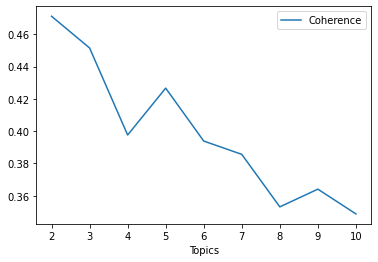

In [90]:
# Nilai Coherenfe tertinggi diperoleh saat alpha = 0,01 dan beta = 0,31
df_plot = df_tuning_result[(df_tuning_result.Alpha == "0.01") & (df_tuning_result.Beta == "0.31") & (df_tuning_result.Validation_Set == "100% Corpus")].copy()
df_plot.plot(x='Topics', y = "Coherence", kind="line")

In [91]:
# dipilih jumlah topik = 2 dengan nilai koherensi terbaik
df_plot_2 = df_tuning_result[(df_tuning_result.Topics == 2) & (df_tuning_result.Validation_Set == "100% Corpus")].copy()
df_plot_2.sort_values(by="Coherence", ascending=False)

,Validation_Set,Topics,Alpha,Beta,Coherence
271,100% Corpus,2,0.01,0.31,0.471215
270,100% Corpus,2,0.01,0.01,0.465669
275,100% Corpus,2,0.31,0.01,0.461592
273,100% Corpus,2,0.01,0.9099999999999999,0.456423
274,100% Corpus,2,0.01,symmetric,0.455964
281,100% Corpus,2,0.61,0.31,0.453294
276,100% Corpus,2,0.31,0.31,0.451959
277,100% Corpus,2,0.31,0.61,0.451959
278,100% Corpus,2,0.31,0.9099999999999999,0.451959
279,100% Corpus,2,0.31,symmetric,0.451959


In [92]:
lda_model = gensim.models.LdaMulticore(
    corpus=doc_term_matrix,
    id2word=dictionary,
    num_topics=2, 
    random_state=100,
    chunksize=100,
    passes=10,
    alpha=0.01,
    eta=0.31
    )
 
pprint(lda_model.print_topics())

[(0,
  '0.046*"ikn" + 0.028*"perintah" + 0.015*"nusantara" + 0.015*"bangun" + '
  '0.013*"kota" + 0.013*"jokowi" + 0.011*"negara" + 0.011*"jakarta" + '
  '0.011*"ruang" + 0.011*"menteri"'),
 (1,
  '0.039*"ikn" + 0.022*"negara" + 0.018*"bambang" + 0.018*"susantono" + '
  '0.018*"jokowi" + 0.018*"kota" + 0.015*"presiden" + 0.015*"otorita" + '
  '0.015*"kepala" + 0.015*"pindah"')]


In [74]:
# Membuat prediksi sentiment menggunakan model yang sebelumnya sudah dibuat
v_data = vectorizer.transform(news_dataframe["berita_clean"]).toarray()
y_classification = model_g.predict(v_data)

news_dataframe["Sentiment"] = list(y_classification)

display(news_dataframe)

,tanggal,deskripsi_berita,berita_clean,Sentiment
0,2022-03-06 06:01:00,Berita terpopuler ekonomi dan bisnis sepanjang...,berita populer ekonomi bisnis sabtu maret tips...,0
1,2022-03-05 09:54:00,KontraS menyoroti langkah pemerintah dalam pem...,kontras sorot langkah perintah pindah kota neg...,0
2,2022-03-05 08:59:00,Menkominfo Johnny Plate menyebutkan ibu kota n...,menkominfo johnny plate kota negara ikn sepenu...,0
3,2022-03-05 06:25:00,KontraS beranggapan proyek IKN berpotensi memi...,kontras anggap proyek ikn potensi picu langgar...,0
4,2022-03-04 20:27:00,Pemerintah terus mengebut persiapan-persiapan ...,perintah kebut siap siap bangun ikn rencana pi...,0
5,2022-03-04 13:42:00,"Ritual, tari, hingga wisata alam bisa di nikma...",ritual tari wisata alam nikmat ikn wilayah mas...,0
6,2022-03-04 13:37:00,PKS menilai tren negatif kepuasan publik terha...,pks nilai tren negatif puas publik presiden jo...,0
7,2022-03-04 11:49:00,Komando Sektor Pertahanan Udara IKN telah terb...,komando sektor tahan udara ikn bentuk markas t...,0
8,2022-03-04 09:55:00,Menteri Luhut Pandjaitan akan segera membentuk...,menteri luhut pandjaitan bentuk tim padu menin...,1
9,2022-03-04 09:13:00,Menteri Luhut Pandjaitan mengatakan Putra Mahk...,menteri luhut pandjaitan putra mahkota raja ar...,0


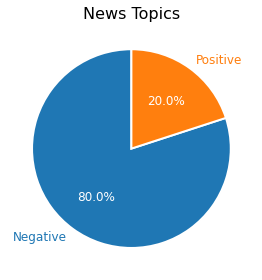

In [75]:
labels = ['Negative', 'Positive']

fig, ax = plt.subplots()
patches, texts, pcts = ax.pie( news_dataframe['Sentiment'].value_counts(), 
        labels=labels, autopct='%.1f%%',
        wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'},
        textprops={'size': 'large'},
        startangle=90
        )
ax.set_title('News Topics', fontsize=16)
plt.setp(pcts, color='white')
fig.set_facecolor('white')
for i, patch in enumerate(patches):
  texts[i].set_color(patch.get_facecolor())
plt.tight_layout()
plt.show()

In [76]:
positive_news = news_dataframe.loc[news_dataframe['Sentiment']==1]
negative_news = news_dataframe.loc[news_dataframe['Sentiment']==0]

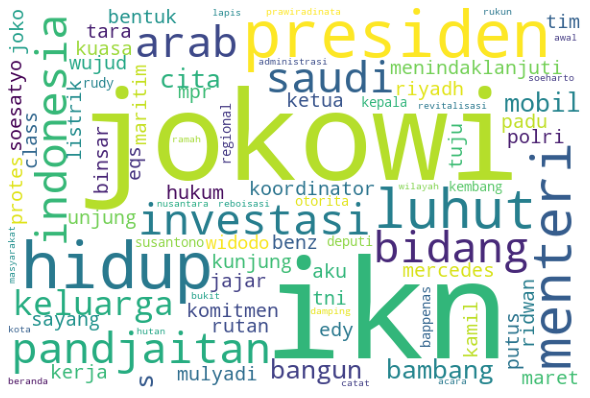

In [77]:
wordcloud_pos_news = WordCloud(width = 600, height = 400,
                background_color ='white',
                min_font_size = 10).generate(' '.join(positive_news['berita_clean']))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_pos_news)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

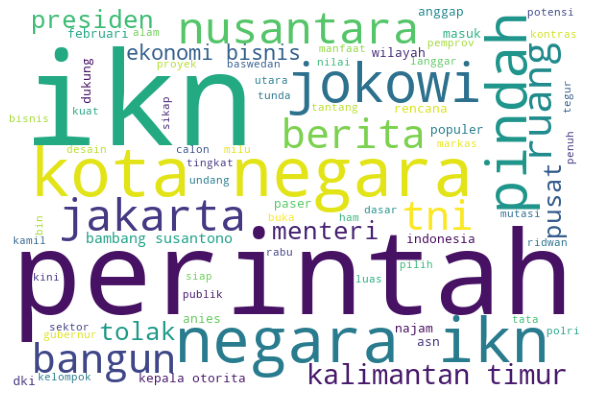

In [78]:
wordcloud_neg_news = WordCloud(width = 600, height = 400,
                background_color ='white',
                min_font_size = 10).generate(' '.join(negative_news['berita_clean']))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_neg_news)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Part 4 - Data Analysis

Analisis opini publik terhadap isu pemindahan ibu kota negara dilakukan menggunakan data 600 tweet sebelum Selasa, 3 Maret 2022. Dari data twitter dilakukan analisis teks dan sentiment. Sedangkan dari data berita dilakukan analisis topic dan sentiment

1. Data Twitter
<br>
<br>
Dari analisis teks data tweets yang diperoleh, dapat disimpulkan bahwa secara garis besar tweets yang muncul adalah mengenai **Dukungan terhadap Pemindahan Ibu Kota Negara**

2. Data Berita
<br>
<br>
Dari ekstraksi topik data ringkasan berita yang diperoleh. Topik utama berita yang muncul mengenai ibu kota negara ada dua, yaitu:
- Presiden Jokowi memutuskan pemindahan ibu kota negara
- Calon CEO Ibu Kota Negara baru

3. Sentiment Keseluruhan
<br>
<br>
Secara keseluruhan, diperoleh sentimen publik cenderung negatif. Meskipun demikian, pada twitter kata yang paling sering muncul kedua adalah **dukung**. Selain itu, ketika dilakukan plot Wordcloud terhadap bigram negatif kedua data, hanya sedikit ditemukan kata-kata negatif dan dengan bobot yang kecil. Maka, dapat disimpulkan bahwa model yang dibuat kurang dapat memprediksi data dengan baik. Hal ini dapat terjadi karena dataset training yang digunakan kurang relevan.